<a href="https://colab.research.google.com/github/Makiato1999/ECG-Detector/blob/main/anomaly_detection_cnn_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import torch, os, platform, sys
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
!nvidia-smi

PyTorch: 2.9.0+cu126
CUDA available: False
/bin/bash: line 1: nvidia-smi: command not found


In [99]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'heartbeat' dataset.
Path to dataset files: /kaggle/input/heartbeat


In [100]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
import os


matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [101]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


# Dataset: Segmented and Preprocessed ECG Signals for Heartbeat

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

Source: https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data?select=ptbdb_normal.csv

In [102]:
normal_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_normal.csv").iloc[:, :-1]
anomaly_df = pd.read_csv("/kaggle/input/heartbeat/ptbdb_abnormal.csv").iloc[:, :-1]
normal_df.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.55,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

In [103]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


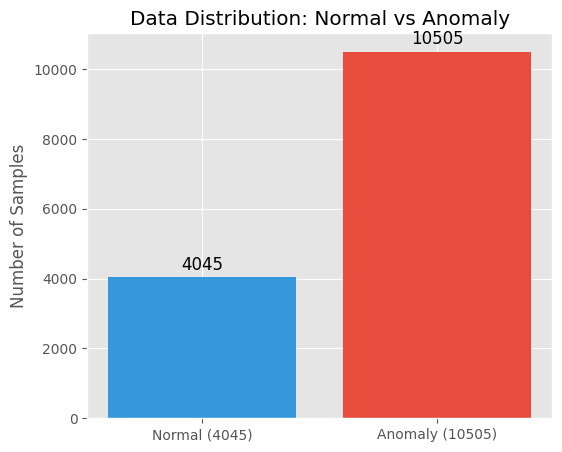

In [104]:
'''
目的：在报告中坦白承认数据是不平衡的，并解释为什么这对 Autoencoder 没问题。
“虽然正常样本较少（约 4000），但足以覆盖标准心跳模式。大量的异常样本（约 10000）将作为极佳的测试集，验证模型的泛化能力。”
'''
# 准备数据
counts = [len(normal_df), len(anomaly_df)]
labels = [f'Normal ({len(normal_df)})', f'Anomaly ({len(anomaly_df)})']
colors = ['#3498db', '#e74c3c']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=colors)

# 在柱状图上标数值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, yval, ha='center', va='bottom', fontsize=12)

plt.title("Data Distribution: Normal vs Anomaly")
plt.ylabel("Number of Samples")
plt.show()

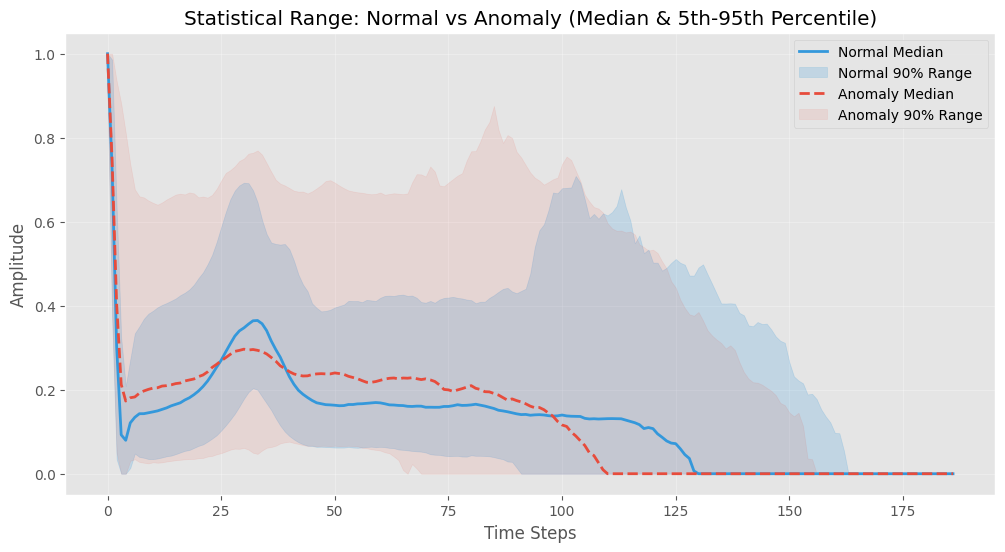

In [105]:
'''
中位数 + 百分位区间 (Median + Percentile Range)

用中位数 (Median)。 既然标准差受分布影响大，我们就用90% 的数据分布区间 (5th - 95th Percentile)。
这样画出来的图，只会显示“大部分数据在哪里”，会过滤掉那些奇怪的 Padding 干扰。
去掉了奇怪的 spikes：因为中位数抗干扰能力强。
保留了 Range：阴影区域依然能让你对比出 Normal 的一致性 vs Anomaly 的混乱性。
'''
def plot_percentile_range(normal, anomaly):
    plt.figure(figsize=(12, 6))

    # 辅助函数：计算分位数
    def get_stats(df):
        # 50% 是中位数 (Median)
        median = np.nanpercentile(df, 50, axis=0)
        # 5% 和 95% 代表绝大多数数据的范围
        lower = np.nanpercentile(df, 5, axis=0)
        upper = np.nanpercentile(df, 95, axis=0)
        return median, lower, upper

    # 1. 计算 Normal 统计量
    norm_mid, norm_low, norm_high = get_stats(normal)

    # 2. 计算 Anomaly 统计量
    anom_mid, anom_low, anom_high = get_stats(anomaly)

    # 画 Normal (蓝色)
    plt.plot(norm_mid, color='#3498db', linewidth=2, label='Normal Median')
    plt.fill_between(range(187), norm_low, norm_high, color='#3498db', alpha=0.2, label='Normal 90% Range')

    # 画 Anomaly (红色)
    plt.plot(anom_mid, color='#e74c3c', linewidth=2, linestyle='--', label='Anomaly Median')
    plt.fill_between(range(187), anom_low, anom_high, color='#e74c3c', alpha=0.1, label='Anomaly 90% Range')

    plt.title("Statistical Range: Normal vs Anomaly (Median & 5th-95th Percentile)")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_percentile_range(normal_df, anomaly_df)

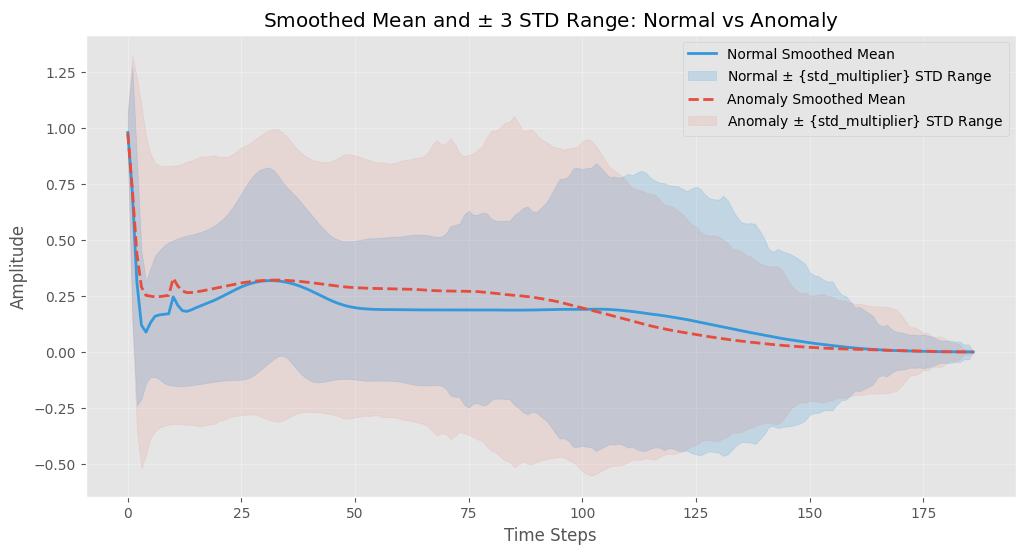

In [159]:
time_steps = normal_df.shape[1] # 187

def calculate_smoothed_mean_stats_fixed(df, std_multiplier=3, window_size=20):
    r"""
    计算平滑均值线和原始数据的 $\pm$ STD 范围。
    """
    mean_signal = df.mean(axis=0)
    std_signal = df.std(axis=0)

    # 3. 对平均信号进行平滑处理 (这是中心线)
    smoothed_mean = mean_signal.rolling(window=window_size, center=True).mean()
    smoothed_mean = smoothed_mean.fillna(mean_signal)

    # 4. 计算基于原始标准差的上下限 (这是范围)
    upper_bound = mean_signal + std_signal * std_multiplier
    lower_bound = mean_signal - std_signal * std_multiplier

    return smoothed_mean.values, lower_bound.values, upper_bound.values

def plot_smoothed_range(normal_df, anomaly_df, std_multiplier=3, window_size=20):
    plt.figure(figsize=(12, 6))

    time_steps_range = range(normal_df.shape[1])

    # 1. 计算 Normal 统计量
    norm_mean, norm_low, norm_high = calculate_smoothed_mean_stats_fixed(
        normal_df, std_multiplier=std_multiplier, window_size=window_size
    )

    # 2. 计算 Anomaly 统计量
    anom_mean, anom_low, anom_high = calculate_smoothed_mean_stats_fixed(
        anomaly_df, std_multiplier=std_multiplier, window_size=window_size
    )

    # --- 绘制 Normal (蓝色) ---
    NORMAL_COLOR = '#3498db'

    # 中心线：平滑均值
    plt.plot(time_steps_range, norm_mean, color=NORMAL_COLOR, linewidth=2, label='Normal Smoothed Mean')

    # 范围阴影： +/- 3 STD 范围
    plt.fill_between(time_steps_range, norm_low, norm_high, color=NORMAL_COLOR, alpha=0.2, label=r'Normal $\pm$ {std_multiplier} STD Range')


    # --- 绘制 Anomaly (红色) ---
    ANOMALY_COLOR = '#e74c3c'

    # 中心线：平滑均值
    plt.plot(time_steps_range, anom_mean, color=ANOMALY_COLOR, linewidth=2, linestyle='--', label='Anomaly Smoothed Mean')

    # 范围阴影： +/- 3 STD 范围
    plt.fill_between(time_steps_range, anom_low, anom_high, color=ANOMALY_COLOR, alpha=0.1, label=r'Anomaly $\pm$ {std_multiplier} STD Range')


    # --- 设置图表样式 (与 percentile range 图表一致) ---
    plt.title(r"Smoothed Mean and $\pm$ 3 STD Range: Normal vs Anomaly")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_smoothed_range(normal_df, anomaly_df)

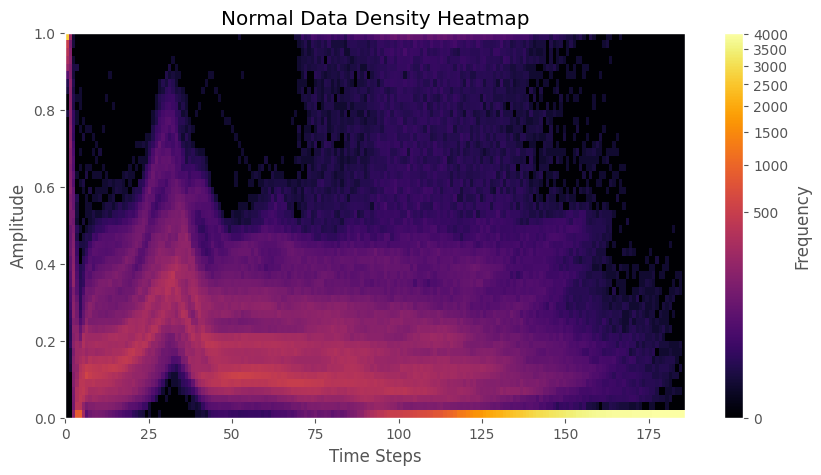

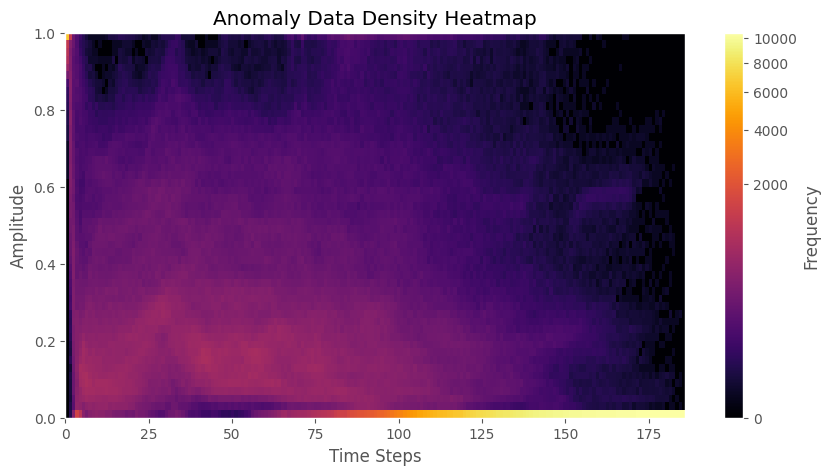

In [106]:
'''
热力密度图 (2D Density Heatmap)

把所有心跳重叠在一起，哪个地方经过的线最多，哪个地方就最亮。
Normal 图：你应该能看到两个非常亮的红/黄色斑点（一个在左边，一个在中间）。这就完美证明了“Normal 数据有两种对齐模式”。
Anomaly 图：应该是一片雾蒙蒙的，没有特别集中的亮斑。
'''
import matplotlib.colors as mcolors

def plot_density_heatmap(df, title):
    # 准备数据：把 x 轴 (0-186) 和 y 轴 (数值) 摊平
    x = np.tile(np.arange(187), len(df))
    y = df.values.flatten()

    plt.figure(figsize=(10, 5))
    # 使用 hist2d 画热力图，bins 设置分辨率
    plt.hist2d(x, y, bins=[187, 50], cmap='inferno', norm=mcolors.PowerNorm(0.3))
    plt.colorbar(label='Frequency')
    plt.title(f"{title} Density Heatmap")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.show()

# 画 Normal 的热力图
plot_density_heatmap(normal_df, "Normal Data")

# 画 Anomaly 的热力图
plot_density_heatmap(anomaly_df, "Anomaly Data")

Normal Data Range: [0.00, 1.00]
Anomaly Data Range: [0.00, 1.00]


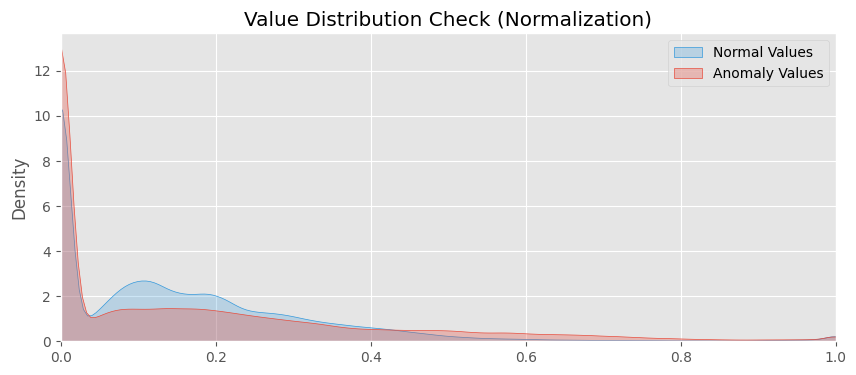

In [107]:
'''
数据已归一化至 [0, 1] 区间，且分布集中。这决定了我们的 Autoencoder 将使用 Sigmoid 激活函数作为输出层
'''
# 快速检查
print(f"Normal Data Range: [{normal_df.min().min():.2f}, {normal_df.max().max():.2f}]")
print(f"Anomaly Data Range: [{anomaly_df.min().min():.2f}, {anomaly_df.max().max():.2f}]")

# 画个简单的分布直方图
plt.figure(figsize=(10, 4))
sns.kdeplot(normal_df.values.flatten(), color='#3498db', fill=True, label='Normal Values')
sns.kdeplot(anomaly_df.values.flatten(), color='#e74c3c', fill=True, label='Anomaly Values', alpha=0.3)
plt.title("Value Distribution Check (Normalization)")
plt.xlim(0, 1)
plt.legend()
plt.show()

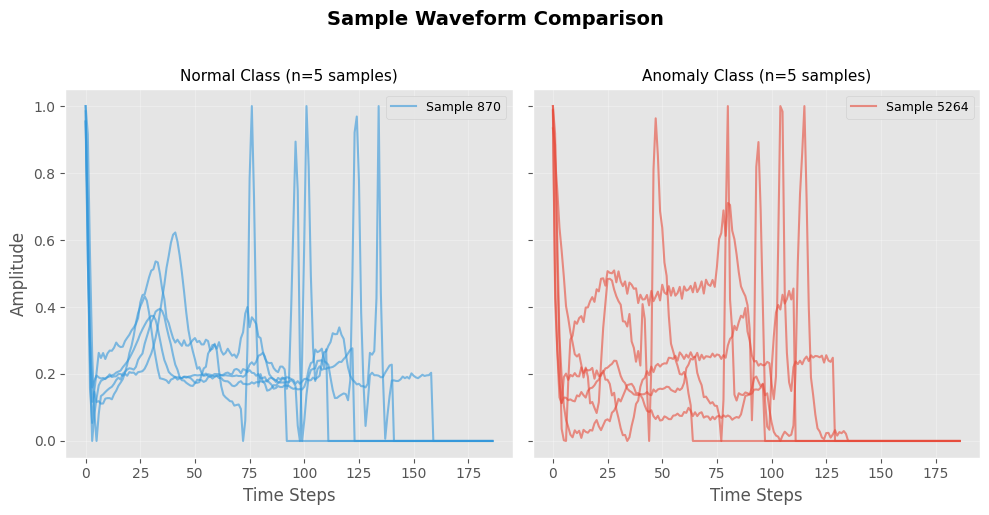

In [164]:
"""
使用少量样本的叠加（Overlay）来可视化 Normal 和 Anomaly 数据的波形。
"""
def plot_sample_overlay(normal_df, anomaly_df, n_samples=5, title="Sample Waveform Comparison"):

    # 随机选择索引
    # 确保样本数量不会超过数据集中实际的样本数
    n_normal = min(n_samples, len(normal_df))
    n_anomaly = min(n_samples, len(anomaly_df))

    normal_indices = np.random.randint(0, len(normal_df), n_normal)
    anomaly_indices = np.random.randint(0, len(anomaly_df), n_anomaly)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

    # --- 左图：Normal Data (蓝色) ---
    NORMAL_COLOR = '#3498db'

    # 叠加绘制 Normal 样本
    for i, idx in enumerate(normal_indices):
        # 使用较高的透明度 (alpha=0.6) 以保证每条线可见，但重叠可见
        label = f"Sample {idx}" if i == 0 else None # 只给第一条线标签，避免图例过长
        ax[0].plot(normal_df.iloc[idx, :].values, color=NORMAL_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[0].set_title(f"Normal Class (n={n_normal} samples)", fontsize=11)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude")
    ax[0].grid(True, alpha=0.3)
    # 移除图例，因为叠加时图例太多会混乱
    # ax[0].legend(loc='upper right', fontsize=9)

    # --- 右图：Anomaly Data (红色) ---
    ANOMALY_COLOR = '#e74c3c'

    # 叠加绘制 Anomaly 样本
    for i, idx in enumerate(anomaly_indices):
        label = f"Sample {idx}" if i == 0 else None
        ax[1].plot(anomaly_df.iloc[idx, :].values, color=ANOMALY_COLOR, alpha=0.6, linewidth=1.5, label=label)

    ax[1].set_title(f"Anomaly Class (n={n_anomaly} samples)", fontsize=11)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.3)
    # ax[1].legend(loc='upper right', fontsize=9)

    plt.suptitle(title, fontsize=14, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()


plot_sample_overlay(normal_df, anomaly_df, n_samples=5)

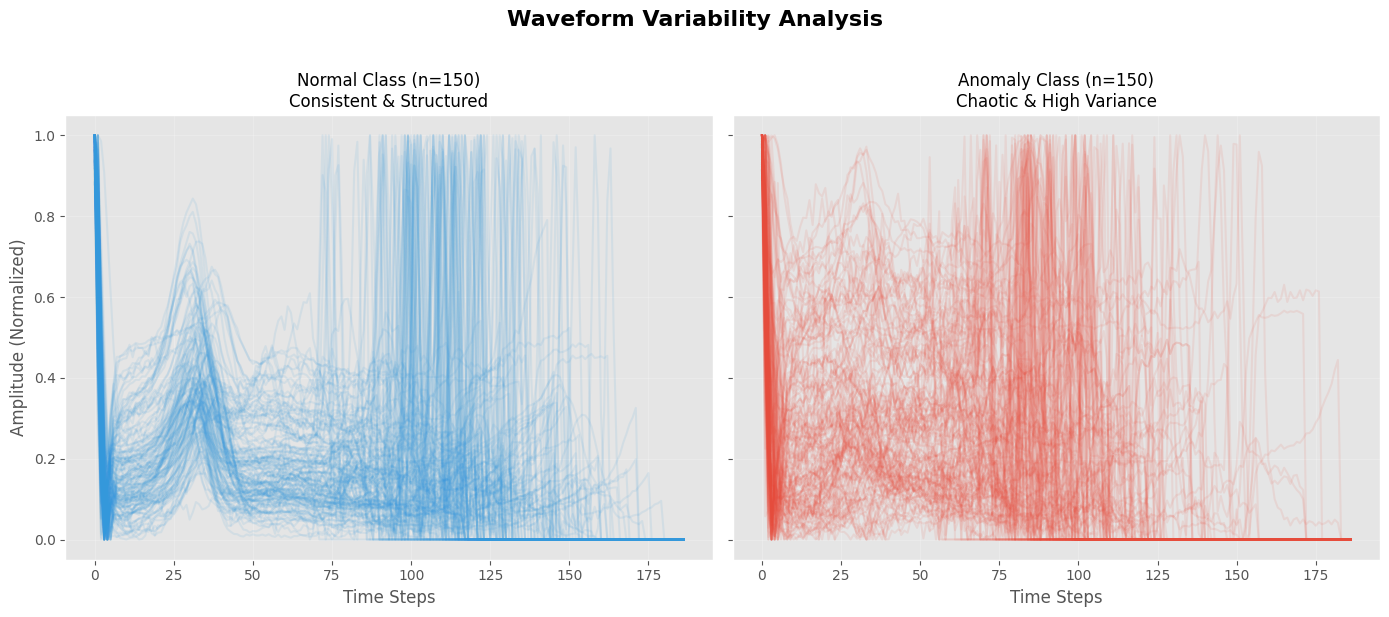

In [165]:
"""
    使用叠加法可视化 ECG 数据的规律性 vs 混乱度
"""
def plot_waveform_overlay(normal, anomaly, n_samples=150, title="Waveform Variability Analysis"):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6))

    # --- 左图：Normal Data (蓝色) ---
    # 随机取样
    normal_indices = np.random.randint(0, len(normal), n_samples)

    # 循环画线，alpha 设置很低(0.1)，让重叠部分显现出来
    for i in normal_indices:
        ax[0].plot(normal.iloc[i, :].values, color='#3498db', alpha=0.1, linewidth=1.5)

    ax[0].set_title(f"Normal Class (n={n_samples})\nConsistent & Structured", fontsize=12)
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Amplitude (Normalized)")
    ax[0].grid(True, alpha=0.2) # 网格淡一点，不要抢戏

    # --- 右图：Anomaly Data (红色) ---
    anomaly_indices = np.random.randint(0, len(anomaly), n_samples)

    for i in anomaly_indices:
        ax[1].plot(anomaly.iloc[i, :].values, color='#e74c3c', alpha=0.1, linewidth=1.5)

    ax[1].set_title(f"Anomaly Class (n={n_samples})\nChaotic & High Variance", fontsize=12)
    ax[1].set_xlabel("Time Steps")
    ax[1].grid(True, alpha=0.2)

    plt.suptitle(title, fontsize=16, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_waveform_overlay(normal_df, anomaly_df, n_samples=150)

In [146]:
# 转换为 NumPy 数组 (必须在 DataLoader 之前完成)
normal = normal_df.to_numpy()
anomaly = anomaly_df.to_numpy() # 异常数据的 NumPy 数组

# 划分正常数据为训练集和验证集
X_train, X_validate = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)

In [142]:
# 定义一个自定义 Dataset 类
class AnomalyDetectionDataset(Dataset):
    """
    自定义Dataset，用于加载自编码器的训练数据。
    自编码器的目标是重构输入，所以 X = Y。
    """
    def __init__(self, data_array):
        # 转换为 PyTorch float32 张量
        self.data = torch.from_numpy(data_array).float()

    def __len__(self):
        # 返回数据集大小
        return len(self.data)

    def __getitem__(self, idx):
        # 返回第 idx 个样本，输入X和目标Y都设置为样本本身
        sample = self.data[idx]
        return sample, sample # (X, Y) 形式

训练 DataLoader 包含的批次数量: 54


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [143]:
# 创建 Dataset 实例
train_dataset = AnomalyDetectionDataset(X_train)
validate_dataset = AnomalyDetectionDataset(X_validate)
anomaly_dataset = AnomalyDetectionDataset(anomaly)

In [144]:
# 创建 DataLoader 实例
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # 训练集需要打乱
    num_workers=4          # 推荐使用多核CPU加速数据加载
)

validate_loader = DataLoader(
    validate_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False          # 验证集不需要打乱
)

anomaly_loader = DataLoader(
    anomaly_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"训练 DataLoader 包含的批次数量: {len(train_loader)}")

训练 DataLoader 包含的批次数量: 54


# CNN Autoencoder Model